# Taller 6 - Evaluación y selección de modelos

## Ejercicio 1 - Metricas de evaluacion para clasificación multiclase

En este ejercicio continuaremos analizando el ejercicio de clasificación de glóbulos blancos del Taller 4. Analizaremos metricas alternativas al accuracy para medir rendimiento, y le aplicaremos pesos a nuestros datos de entrenamiento para balancear las clases en el entrenamiento.

In [ ]:
#@title Preámbulo
import numpy as np
import numpy.random as rng

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import re
import os
import sys


!mkdir -p data
!wget -c --quiet  http://iie.fing.edu.uy/~nacho/data/globulos/globulos_blancos.zip
!unzip -q -o -d data globulos_blancos.zip
!wget -qO  etiquetas.csv http://iie.fing.edu.uy/~nacho/data/globulos/labels.csv

mapname:  conversion of  failed


# Carga y preprocesamiento de datos

Las siguientes lineas condensan las operaciones vistas en el taller 4 para el caso de la representación basada en Local Binary Patterns:

* carga de imagen
* restaltado de marcadores (restando colores rojo y azul)
* cálculo de máscara binaria mediante umbralización
* limpieza de la máscara usando morfología (`morph`)
* cálculo de características LBP

Por ahora, guardamos todos los datos en un diccionario.



In [ ]:
#@title Carga y preprocesamiento
#
# bibliotecas necesarias
#
import csv # para leer CSVs
from skimage import morphology as morph # para limpiar máscaras binarias
from skimage.feature import local_binary_pattern # autoexplicativo

#
# cargamos las imágenes
#
classes = ['NEUTROPHIL', 'MONOCYTE', 'EOSINOPHIL', 'LYMPHOCYTE']
class_num = range(len(classes))
nclasses = len(classes)
#
# cargamos las etiquetas
# descartamos las lineas sin etiqueta
# la info de las etiquetas es una tabla CSV (Comma Separated Values)
# de la forma:  ,numero de imagen, etiqueta(s) (la primera columna está vacía)
#
radio = 3            # parámetro modificable
n_puntos = 8*radio   # parámetro modificable
nbins = n_puntos+1   # número de patrones posibles
ndim  = nbins        # dimensión de features: cantidad de elementos en el histograma

datos = list()
with open('etiquetas.csv') as csv_file:
  csv_reader = csv.reader(csv_file,delimiter=',',quotechar='"',skipinitialspace=True)
  next(csv_reader) # salteamos la primera fila, que es el encabezado
  show = True
  for i,row in enumerate(csv_reader): # para cada fila en el archivo
    num = int(row[1])
    label = row[2].strip() # strip saca espacios a los costados
    fname = os.path.join("data",f"BloodImage_{num:05d}.jpg")
    if os.path.exists(fname) and label in classes:
      #
      # cargamos imagen
      #
      im = plt.imread(fname).astype(np.uint8)
      #
      # restamos canales azul y rojo para resaltar marcadores
      #
      markers = 128 + im[:,:,2]/2 - im[:,:,0]/2
      #
      # umbralizamos
      #
      mask   = markers > 150
      #
      # limpiamos máscara
      #
      mask = morph.remove_small_objects(mask,1000)
      #
      # extraemos LBP
      #
      lbp = local_binary_pattern(mask,P=n_puntos, R=3, method='uniform')
      histogram, _ = np.histogram(lbp.ravel(), bins=n_puntos+1)
      if show:
        print(lbp.shape)
        print(histogram)
        show = False
      if i > 0 and not i % 10:
        print(f"{i:5}")
      #
      # guardamos datos
      #
      label_num = classes.index(label)
      muestra = {'num':num,'image':im,'markers':markers,'mask':mask,'features':histogram,'label':label,'label_num':label_num }
      datos.append(muestra)

print("numero de muestras: ",len(datos))

(480, 640)
[     2      8     18     21     50     85      0    154    282    253
    302    364      0    417    379    460    274    285      0    287
    368    330    384 302123    354]
   20
   30
   40
   50
   90
  100
  110
  120
  130
  140
  150
  160
  170
  180
  190
  200
  210
  220
  230
  240
  250
  260
  270
  290
  300
  310
  320
  330
  340
  350
  360
  370
  390
  400
  410
numero de muestras:  347


In [ ]:
#@title Preparación de los datos para entrenamiento
#
# aquí convertimos la parte que nos interesa de los datos cargados a matrices
# en donde la i-ésima fila de X tiene las características de la i-ésima muestra
# (histograma de LBP) y el i-ésimo elemento de y tiene la etiqueta correspondiente.
#
ndatos = len(datos)
X = np.empty((ndatos,ndim))
y = np.empty((ndatos),dtype=int)
y_onehot = np.empty((ndatos,nclasses))
y_text = list()
for i in range(ndatos):
  X[i,:] = datos[i]["features"]
  y[i] = datos[i]["label_num"]
  y_onehot[i,y[i]] = 1
  y_text.append(datos[i]["label"])


## Desbalance de clases

Cuando se trata de clasificar, y la métrica de evaluación es la tasa de acierto, es muy importante tener en cuenta el _desbalance de clases_. Si el 99% de las muestras fuera de una clase mayoritaria, entonces con dictaminar que todas las muestras son de esa clase tendríamos un desempeño del 99%, pero eso no es lo que uno quiere normalmente.



In [ ]:
def count(_y,_classes):
  _nsamples = len(_y)
  _nclasses = len(_classes)
  counts = dict()
  for _k in range(_nclasses):
    _class_name  = _classes[_k]
    _class_count = np.sum(_y == _k)
    counts[_class_name] = _class_count
  return counts

def print_counts(_counts):
  for c in _counts.keys():
    p = _counts[c]/len(y)
    print(f"{c:12}: {_counts[c]:3} ({100*p:5.1f}% )")

counts = count(y,classes)
print_counts(counts)

NEUTROPHIL  : 206 ( 59.4% )
MONOCYTE    :  20 (  5.8% )
EOSINOPHIL  :  88 ( 25.4% )
LYMPHOCYTE  :  33 (  9.5% )


# Estratificación

Como ya vimos en los prácticos anteriores, la separación en conjuntos de entrenamiento y test es una parte fundamental de la metodología de aprendizaje automático.

Cuando hay desbalance de clases, queremos que las distintas clases estén igualmente representadas en ambos conjuntos. Llamamos _estratificación_ al proceso de separación (aleatoria) que tiene en cuenta este aspecto.

**Ejercicio:** Para que `train_test_split` sea estratificado es necesario pasarle un argumento opcional de nombre `stratify` cuyo valor es la lista de etiquetas correspondiente al conj. de entrenamiento (en nuestro caso puede ser `y` o `l`). Realice lo siguiente:

* corra el código de abajo tal cual está (sin estratificación)
* observe la cantidad de ocurrencias de cada clase en cada subconjunto
* agregue la opción mencionada a `train_test_split`
* vuelva a correr el código y observe las diferencias en cantidades

In [ ]:
#@title Separación en conjuntos de entrenamiento y validación

from sklearn.model_selection import train_test_split
#
# EJERCICIO: agregue el argumento 'stratify'  con el valor correspondiente (stratify=...)
# para que la división sea estratificada
#
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, random_state=42)

print('ocurrencias en y:')
ctotal = count(y,classes)
print_counts(ctotal)

print('\nocurrencias en ytrain:')
ctrain = count(ytrain,classes)
print_counts(ctrain)

print('\nocurrencias en ytest:')
ctest = count(ytest,classes)
print_counts(ctest)


ocurrencias en y:
NEUTROPHIL  : 206 ( 59.4% )
MONOCYTE    :  20 (  5.8% )
EOSINOPHIL  :  88 ( 25.4% )
LYMPHOCYTE  :  33 (  9.5% )

ocurrencias en ytrain:
NEUTROPHIL  : 164 ( 47.3% )
MONOCYTE    :  19 (  5.5% )
EOSINOPHIL  :  68 ( 19.6% )
LYMPHOCYTE  :  26 (  7.5% )

ocurrencias en ytest:
NEUTROPHIL  :  42 ( 12.1% )
MONOCYTE    :   1 (  0.3% )
EOSINOPHIL  :  20 (  5.8% )
LYMPHOCYTE  :   7 (  2.0% )


## Clasificación básica

A continuación entrenamos un clasificador de regresión con penalización L2, y lo testeamos en nuestros datos para obtener la accuracy.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
#
# preprocesamiento (normalización)
#
scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain_scaled = scaler.transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)
#
# regresión logística tipo Ridge (penalización cuadrática)
# el parámetro C es como el alpha de RidgeRegression o Lasso:
# controla la regularización.
#
basic = LogisticRegression(penalty='l2',C=0.5,max_iter=1000)
basic.fit(Xtrain_scaled, ytrain)
pred_basic = basic.predict(Xtest_scaled)
score_basic = np.sum(pred_basic == ytest)/len(ytest)
print(f"La accuracy del modelos básico es: {score_basic*100:.2f}%")

La accuracy del modelos básico es: 61.43%


**Ejercicio 2:** ¿Le parece que la accuracy obtenida es buena? Considere que un clasificador aleatorio que asigne una de las 4 clases al azar (elegidas con igual probabilidad) tendría un rendimiento de 25%. Considere también las frecuencias relativas de las clases.

*Inserte su respuesta aquí*

## Matriz de confusión

La matriz de confusión nos permite ver el desempeño del clasificador por cada clase.



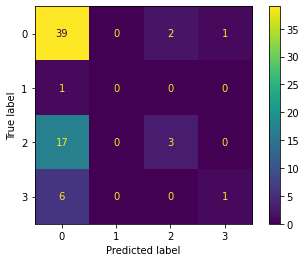

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#
# generamos la matriz de confusion
#
conf_basic = confusion_matrix(y_true=ytest, y_pred=pred_basic)
#
# la visualizamos
#
mc_plot = ConfusionMatrixDisplay(confusion_matrix=conf_basic, display_labels=basic.classes_)
mc_plot.plot()
plt.show()

**Ejercicio 3:** Vuelva a responder la pregunta anterior, ahora con la matriz de confusión a la vista.

*Inserte su respuesta aquí*

## Métricas ajustadas al desbalance

Para obtener una evaluación más cuantitativa de los resultados, extraeremos las métricas de rendimiento para clasificadores: la precisión, el recall y el f1-score. Abajo, los *macro avg* muestran el promedio de estas cantidades entre las clases, y el *micro avg* el promedio pesando a cada clase según la cantidad de ejemplos que tiene.

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(ytest, pred_basic))

              precision    recall  f1-score   support

           0       0.62      0.93      0.74        42
           1       0.00      0.00      0.00         1
           2       0.60      0.15      0.24        20
           3       0.50      0.14      0.22         7

    accuracy                           0.61        70
   macro avg       0.43      0.31      0.30        70
weighted avg       0.59      0.61      0.54        70



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Ejercicio 4:** Discuta brevemente los resultados que se observan en la tabla, y su relación con la matriz de confusión.

*Inserte su respuesta aquí*

A continuación, entrenaremos un nuevo modelo, pero aplicándole pesos a los datos de entrenamiento, de forma que cada clase tenga el mismo peso total. Para ello a cada dato le aplicamos un peso igual al inverso de la frecuencia de su clase.

In [ ]:
# Primero obtenemos el peso de cada clase, tomando el inverso de su frecuencia
ntrain = len(ytrain)
wclass = np.ones(nclasses)
for c in range(nclasses):
  wclass[c] = ntrain/ctrain[classes[c]]
  print(f'peso de clase {classes[c]:12}: {wclass[c]:8.3f}')

wtrain = np.ones(len(ytrain))
for i in range(len(ytrain)):
  wtrain[i] = wclass[ytrain[i]]

print("Los primeros 10 elementos del vector de pesos generados son:")
print(wtrain[1:10])

peso de clase NEUTROPHIL  :    1.689
peso de clase MONOCYTE    :   14.579
peso de clase EOSINOPHIL  :    4.074
peso de clase LYMPHOCYTE  :   10.654
Los primeros 10 elementos del vector de pesos generados son:
[4.07352941 4.07352941 1.68902439 1.68902439 4.07352941 1.68902439
 1.68902439 1.68902439 1.68902439]


In [ ]:
# Luego entrenamos un nuevo clasificador logístico con regularización L2, usando los pesos
weighted = LogisticRegression(penalty='l2',C=20,max_iter=1000)
weighted.fit(Xtrain_scaled, ytrain, sample_weight=wtrain) # A la función fit le agregamos el parámetro de los pesos
pred_weighted = weighted.predict(Xtest_scaled)
score_weighted = np.sum(pred_weighted == ytest)/len(ytest)
print(f"La accuracy del modelos con clases balanceadas es: {score_weighted*100:4.2f}% \n")

La accuracy del modelos con clases balanceadas es: 61.43% 



**Ejercicio 5:** Grafique la matriz de confusion del nuevo modelo, e imprima las medidas de rendimiento de clasificación.

In [ ]:
# Inserte su codigo aqui

**Ejercicio 6:** Discuta brevemente las diferencias de comportamiento de este nuevo modelo con respecto al modelo anterior, y cómo se ven reflejados en la matriz de confusion y en las métricas de rendimiento. ¿Cree que se puede decir que el modelo entrenado con pesos es mejor? Justifique.

*Inserte su respuesta aquí*

**Ejercicio extra:** A veces los diferentes errores que puede cometer un modelo tienen diferente costo. Por ejemplo, si un modelo se usa para diagnosticar cáncer y determinar si a un paciente se le da el alta o si se le hacen más estudios, es más costoso darle el alta erroneamente a un paciente con cáncer que pedirle más estudios a un paciente sano.

Supongamos que en nuestro problema es importante clasificar correctamente a las células de clase LYMPHOCYTE. Proponga una forma de aumentar el rendimiento para esta clase en el modelo, usando las herramientas vistas arriba. Implemente el nuevo modelo, visualice la matriz de confusión e imprima las medidas de rendimiento.

**Pista:** Le puede ser útil modificar los pesos de las clases utilizados en el ejemplo anterior.

## Ej 2 - Cross Validation y Seleccion de parametros

### Preliminares

Revisitemos el problema del taller 5, en el cual el objetivo es clasificar hojas de plantas según su especie en base a imágenes. Supongamos que tenemos que entregar el sistema a un cliente y que debemos indicar el _accuracy_ esperado del sistema para cualquier nuevo dato ingresado en el futuro.

**Preguntas:**
* ¿Sería el accuracy obtenido en el taller 5 una buena estimación?
* Si no, ¿por qué?
* ¿Qué se puede hacer para proveer una mejor estimación?


*Puede responder aqui*

## K-fold cross validatron

Veremos ahora cómo entrenar nuestro modelo usando k-folds cross validation para tener una estimación más robusta del _accuracy_.

Primero volvemos a importar las imagenes y datos ([train.csv](https://drive.google.com/file/d/1zFLrWMs8HL_wZSPoXMISUE3yHdcS1HQu/view?usp=sharing)).

In [ ]:
# Paquete para redimensionar las imagenes sin deformarlas
!wget --quiet -c -O train.csv  https://iie.fing.edu.uy/~nacho/data/hojas/train.csv
!wget --quiet -c -O test.csv   https://iie.fing.edu.uy/~nacho/data/hojas/test.csv
!wget --quiet -c -O images.zip https://iie.fing.edu.uy/~nacho/data/hojas/images.zip
!unzip -u images.zip
import keras
from PIL import Image
from keras.utils import img_to_array
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation, Input, Flatten, Conv2D, MaxPooling2D, BatchNormalization



Archive:  images.zip


In [ ]:
import pandas as pd
train = pd.read_csv('./train.csv')
# Los datos de margen, forma y textura seran nuestra entrada
x = train.drop(['species','id'],axis=1)
# La especie nuestra salida, lo que queremos predecir
y = train['species']
# id de la imagen a la que corresponden los datos
ids = train['id']

img_path = 'images/'

# Generaremos imagenes cuadradas de tamaño fijo
# con la imagen de la hoja centrada y a escala
size=200
data = []
for ID in ids:
    img = Image.open(img_path+str(ID)+".jpg")
    img.thumbnail((size,size))
    img_nueva = Image.new("1", (size,size), 0)
    img_nueva.paste(img, ( int((size - img.size[0]) / 2), int((size - img.size[1]) / 2) ))
    data.append(img_to_array(img_nueva))
np.array(data).shape

(990, 200, 200, 1)

In [ ]:
x = np.array(data)
y = LabelEncoder().fit(y).transform(y)
y_cat = to_categorical(y)
x_train , x_test , y_train_cat , y_test_cat = train_test_split(x, y , test_size = 0.25 , random_state = 42)

**Ejercicio 1:**
Entrenen su modelo una vez sobre los datos particionados para luego poder comparar.

In [ ]:
# Busquen un modelo que les haya traido resultados buenos
# pero tal vez no el que les llevo una hora de entrenamiento.
# Recuerden que le K-folds CV va a entrenar muchas veces.

Probemos analizar el rendimiento de un modelo sobre K particiones (folds) con el algoritmo K-folds.

*Recordatorio del algoritmo:* divide lo que definamos como set de entrenamiento en K partes, y entrena K veces el modelo (siempre desde cero) sobre todas las particiones menos una, y la que se deja afuera se usa para evaluar (set de validacion).

**Ejercicio 2:** El codigo de abajo lo implementa con un modelo de ejemplo, prueben con el suyo!

In [ ]:
from sklearn.model_selection import KFold

num_particiones=4

# Define el iterador K-fold Cross Validator
kfold = KFold(n_splits=num_particiones, shuffle=True)

# Define listas para guardar los resultados sobre cada particion
acc_por_particion = []
loss_por_particion = []

# Evaluacion del modelo usando K-fold Cross Validation
particion_num = 1
for train, test in kfold.split(x,y_cat):

  # Define la arquitectura del modelo
  model = Sequential()
  model.add(Input(shape=(200,200,1)))
  model.add(Conv2D(32, (5,5)))
  model.add(MaxPooling2D((2,2)))
  model.add(Conv2D(32, (5,5)))
  model.add(MaxPooling2D((2,2)))
  model.add(Conv2D(16, (3,3)))
  model.add(MaxPooling2D((2,2)))
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Dropout(0.3))
  model.add(Activation('sigmoid'))
  model.add(Dense(99))
  model.add(Activation('softmax'))

  # Compila el modelo
  model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=["accuracy"])

  # Imprime entrenamiento para la particion
  print('------------------------------------------------------------------------')
  print(f'Entrenando la partición numero {particion_num}...')

  # Ajuste del modelo a los datos de la particion
  history = model.fit(x[train], y_cat[train],
              batch_size=32,
              epochs=20,
              verbose=1)

  # Imprimir y guardar los puntajes sobre la particion de testeo
  scores = model.evaluate(x[test], y_cat[test], verbose=0)
  print(f'Score for fold {particion_num}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_por_particion.append(scores[1] * 100)
  loss_por_particion.append(scores[0])

  # Aumentar el numero de particion
  particion_num = particion_num + 1

------------------------------------------------------------------------
Entrenando la partición numero 1...
Epoch 1/20
 7/24 [=======>......................] - ETA: 46s - loss: 4.7335 - accuracy: 0.0491

KeyboardInterrupt: ignored

In [ ]:
# Puntaje promedio
print('Puntaje por partición')
for i in range(0, len(acc_por_particion)):
  print(f'> Partición {i+1} - Loss: {loss_por_particion[i]} - Accuracy: {acc_por_particion[i]}%')
print('------------------------------------------------------------------------')
print('Rendimiento promedio para todas las particiones:')
print(f'> Accuracy: {np.mean(acc_por_particion)} (+- {np.std(acc_por_particion)})')
print(f'> Loss: {np.mean(loss_por_particion)}')

Puntaje por partición
------------------------------------------------------------------------
Rendimiento promedio para todas las particiones:
> Accuracy: nan (+- nan)
> Loss: nan


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Como pueden ver, en cierta forma esto nos da mas informacion sobre los datos.

**Pregunta 3:** ¿Que concluyen de la variacion del accuracy para cada partición?


**Pregunta 4:** ¿Tiene sentido hacer CV sobre el modelo con las capas que augmentan los datos?

*Pueden responder aqui*

## Ej 2.2 - Grid Search de parametros con Cross Validation

A lo largo de casi todos los ejercicios de los talleres, les hemos pedido que implementen algoritmos y modelos que muchas veces dependen de parametros definidos por el usuario. Casi siempre les proponiamos como ejercicio o experimento, que modificaran estos valores y vieran como variaban los resultados.

Como vimos la clase pasado, hay formas de implementar busquedas de combinaciones de parametros que automaticen y hagan de esta decision (el valor del parametro) algo un poco menos aleatorio.

Sklearn tiene una funcion para implementar un grid search, donde se define el clasificador que se utilizara y un array de valores que queremos que tome uno o varios parametros.

A modo de ejemplo usaremos los datos precalculados de las hojas. Elegimos estos datos (que son bastante livianos) ya que el grid search puede ser una tarea lenta (se prueban todas las combinaciones de parametros y se hace cross validation sobre todas) y no queremos que se pasen el resto del taller mirando la pantalla.

Recuerden que ya con un clasificador Random Forest y con una red neuronal simple, habiamos obtenido muy buenos resultados sobre estos datos! Ahora el desafio esta en mover el accuracy de test un poquito mas cerca de 100%.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
train = pd.read_csv('./train.csv')

# Los datos de margen, forma y textura seran nuestra entrada
x = train.drop(['species','id'],axis=1)

x = StandardScaler().fit(x).transform(x)
print(x.shape, x.mean(), x.std())

y = train['species']
y = LabelEncoder().fit(y).transform(y)
ids = train['id']

# Separamos los datos en un conjunto de entrenamiento y otro de prueba
x_train , x_test , y_train , y_test = train_test_split(x , y , test_size = 0.25 , random_state = 42)

(990, 192) -6.8407681315287425e-18 0.9999999999999999


In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(x_train , y_train)

RandomForestClassifier()

In [ ]:
print(classifier.score(x_test, y_test))

0.9798387096774194


**Ejercicio 1:** Intenten mejorar el resultado optimizando los parametros con un grid search.

Conviene comenzar creando una grilla de parametros a probar a partir de valores por default o que fueron probados y tienen sentido. Recuerden consultar la documentacion de sklearn en caso de no recordar que hace algun parametro!

In [ ]:
from sklearn.model_selection import GridSearchCV
# Definir grilla
param_grid = {
    'max_depth': [90, 100, 110],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [ ]:
# Crear un modelo
rf = RandomForestClassifier()
# Crear un modelo de Grid Search
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)
grid_result = grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 324 candidates, totalling 972 fits


Veamos cual es la combinacion optima de paramtros y que rendimiento tienen.

El CV en "GridSearchCV" hace referencia a que los valores de accuracy son obtenidos con cross validation, por lo cual son una buena estimacion, pero debemos guardar un set de testeo, ya que los datos de validacion estaran siendo utilizados para elegir los parametros y por lo tanto dejan de ser desconocidos para el modelo.

In [ ]:
print( "Mejores Parametros:")
print(grid_search.best_params_)

print()
mejor_modelo = grid_search.best_estimator_

print('Rendimiento del mejor modelo:')
print('Accuracy = {:0.2f}%.'.format(100*mejor_modelo.score(x_test, y_test)))


Mejores Parametros:
{'max_depth': 100, 'max_features': 2, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 1000}

Rendimiento del mejor modelo:
Accuracy = 95.97%.


Antes de terminar probemos hacer esto con un modelo de Keras. Tiene una pequena vuelta (hay que usar un wrapper de sklearn para keras) pero es algo que sera muy util.

En el ejemplo a continuacion variamos la cantidad de Neuronas de una capa de una red neuronal, y la funcion de optimizacion del entrenamiento (entre 4 funciones muy populares).

**Ejercicio 2:** Prueben agregar mas capas o hacer el grid search para otro valor, como el dropout o el batch size.

In [ ]:
y_train_cat = to_categorical(y_train)

In [ ]:
!pip install scikeras

from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

# Debemos definir una funcion que cree el modelo
# esto ser'a lo que le pasemos a la funcion KerasClassifier
def crear_modelo(optimizer='adam', neuronas=512):
  # crear el modelo
  model = Sequential()
  model.add(Dense(neuronas,input_dim=192))
  model.add(Dropout(0.2))
  model.add(Activation('sigmoid'))
  model.add(Dense(99))
  model.add(Activation('softmax'))
  # Compila el modelo
  model.compile(loss='categorical_crossentropy',optimizer=optimizer, metrics=["accuracy"])
  return model


# fijar la random seed para reproducibilidad
seed = 42
np.random.seed(seed)

# crear modelo con el "envoltorio" KerasClassifier
model = KerasClassifier(build_fn=crear_modelo, epochs=40, batch_size=32, verbose=1)

# definir parametros para el grid search:
# Estas siete funciones son algunas de las mas populares,
# alguna son mas recientes y otras forman parte de la historia de las redes neuronales
# la documentacion de Keras tiene explicaciones cortas y claras, pero se puede encontrar
# muy buen material al respecto por ah'i
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adam']
# neuronas = [256, 512, 1024]
# param_grid = dict(optimizer=optimizer, neurons=neuronas)

param_grid = {
    'model__optimizer': ['SGD', 'RMSprop', 'Adagrad', 'Adam'],
    'model__neuronas' : [256, 512, 1024]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train_cat)

# resumen de los resultados
print("Mejor accuracy: %f usando %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) con: %r" % (mean, stdev, param))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Epoch 1/40
24/24 [==============================] - 1s 3ms/step - loss: 4.4304 - accuracy: 0.0943
Epoch 2/40
24/24 [==============================] - 0s 3ms/step - loss: 3.6826 - accuracy: 0.4070
Epoch 3/40
24/24 [==============================] - 0s 3ms/step - loss: 3.2125 - accuracy: 0.5580
Epoch 4/40
24/24 [==============================] - 0s 4ms/step - loss: 2.7812 - accuracy: 0.6658
Epoch 5/40
24/24 [==============================] - 0s 3ms/step - loss: 2.3933 - accuracy: 0.7574
Epoch 6/40
24/24 [==============================] - 0s 4ms/step - loss: 2.0622 - accuracy: 0.8261
Epoch 7/40
24/24 [==============================] - 0s 4ms/step - loss: 1.7580 - accuracy: 0.8720
Epoch 8/40
24/24 [==============================] - 0s 3ms/step - loss: 1.4858 - accuracy: 0.9124
Epoch 9/40
24/24 [==============================] - 0s 4ms/step - loss: 1.2569 - accuracy: 0.9299
Epoch 10/40
24/24 [==============================] - 0s 3ms/step - loss: 1.0461 - accuracy: 0.9582
Epoch 11/40
24/24 [

Comenten las opciones que probaron y como obtuvieron los mejores resultados.